# Trafic accidents (Ilias SAGHIR)

**Goal** : predict whether a car accident is serious or not based on attributes such as : time and space circumstances, road and vehicle characteristics, usage of safety gear, driver and passenger info...

**Data** : For this, we will use the 2018 public data provided by the French ministry of transport which can be found on [this page](https://www.data.gouv.fr/fr/datasets/base-de-donnees-accidents-corporels-de-la-circulation/#_).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
charac=pd.read_csv('caracteristiques-2018.csv',encoding='ISO-8859-1')
user=pd.read_csv('usagers-2018.csv',encoding='ISO-8859-1')
loc=pd.read_csv('lieux-2018.csv',encoding='ISO-8859-1')

**charac** : accident circumstances : time, place, weather, lighting...

**user** : info on the people involved

**loc** : info on the place of accident : road type, circulation...

In [30]:
#Merging tables by accident/user/location correspondences

df=pd.merge(user, pd.merge(charac, loc, on='Num_Acc'), on='Num_Acc').drop(columns=['Num_Acc'])

#Dataset provides 4 categories for accident gravity, we will simplify by only considering 2 categories (serious vs non serious)

df['grav']=((df['grav']==2) | (df['grav']==3))
print(df['grav'].sum(),len(df))

25561 130169


There is a noticeable class imbalance which we should account for in training and in the evaluation of our model.

We choose to eliminate some attributes and only keep possibly relevent ones.

In [31]:
df=df[['grav','lum','agg','int','atm','catr','circ','nbv','prof','plan','surf','infra','catu','sexe','an_nais','secu']]

This next preprocessing step encodes the categorical variables into dummy variables (0-1), this helps the model further discriminate important values for the variables, and enables us to use a logistic regression.

In [32]:
df=df.dropna()

for c in df.columns:
    if c in ['lum','int','atm','circ','prof','plan','infra','catu','surf']:
        m=int(max(df[c]))
        for i in range(1,m+1):
            df[c+str(i)]=(df[c]==i)
        df=df.drop(columns=c)
    elif c in ['agg','sexe']:
        df[c]=(df[c]==2)
    elif c=='catr':
        for i in range(1,7):
            df[c+str(i)]=(df[c]==i)
        df=df.drop(columns=c)
    elif c=='an_nais':
        df['age']=(2018-df[c])/(2018-min(df[c]))
        df=df.drop(columns=c) 
    elif c=='secu':
        df[c]=df[c].astype(int)
        df['secu1']=df[c].apply(lambda x:int(str(x)[-1])==1)
        df['secu2']=df[c].apply(lambda x:int(str(x)[-1])==2)
        df=df.drop(columns=c)

In [33]:
df

,grav,agg,nbv,sexe,lum1,lum2,lum3,lum4,lum5,int1,...,infra4,infra5,infra6,infra7,catu1,catu2,catu3,age,secu1,secu2
0,True,False,2.0,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,0.841121,True,False
1,False,False,2.0,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,0.542056,True,False
2,False,True,2.0,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,0.663551,True,False
3,False,True,2.0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,0.551402,False,True
4,True,True,2.0,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,0.289720,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130164,False,True,2.0,False,False,False,False,False,True,True,...,False,False,False,False,False,False,True,0.401869,False,False
130165,False,True,2.0,True,False,False,False,False,True,True,...,False,False,False,False,True,False,False,0.233645,True,False
130166,False,True,2.0,False,False,False,False,False,True,True,...,False,False,False,False,True,False,False,0.411215,True,False
130167,False,True,2.0,False,True,False,False,False,False,True,...,False,False,False,False,True,False,False,0.420561,True,False


We now have 66 attributes consisting of dummy variables and continuous variables

In [34]:
features=df.columns.drop('grav')

We construct our train/test sets using the train_test_split function, but we make sure that our training set contains the same proportion of both classes to avoid a bias in our model, hence the undersampling

In [35]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3,random_state=42)

#undersampling
X_train_1=train.loc[train['grav']==1,features]
y_train_1=train.loc[train['grav']==1,'grav']
X_train_2=train.loc[train['grav']==0,features].head(n=len(X_train_1))
y_train_2=train.loc[train['grav']==0,'grav'].head(n=len(X_train_1))

X_train=pd.concat([X_train_1,X_train_2],axis=0)
y_train=pd.concat([y_train_1,y_train_2],axis=0)

X_test=test[features]
y_test=test['grav']

We use either a logistic regression or a GradBoost model, we notice that the latter performs better

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

model=GradientBoostingClassifier()
#model=LogisticRegression(max_iter=300)
model.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

For evaluation, we first measure the main scores of the model : accuracy, precision, recall and F-score

In [40]:
y_pred=model.predict(X_train)
print("Train accuracy : ",np.mean(y_pred==y_train))

y_pred=model.predict(X_test)
print("Test accuracy : ",np.mean(y_pred==y_test))

from sklearn.metrics import precision_recall_fscore_support

print(precision_recall_fscore_support(y_test, y_pred, average='macro'))

Train accuracy :  0.6971572810866038
Test accuracy :  0.7120713195727251
(0.6301721366254274, 0.6877343948837291, 0.6348892180149872, None)


Since the classes are not balanced, another evaluation method is to plot the ROC and precision-recall curves, and calculate the AUC scores for each.

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.749


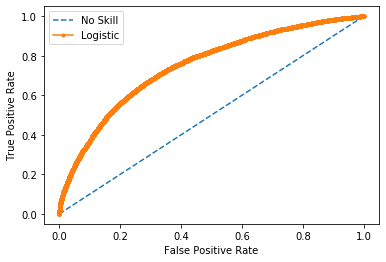

In [42]:
# roc curve and auc

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ns_probs = [0 for _ in range(len(y_test))]
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Model: auc=0.444


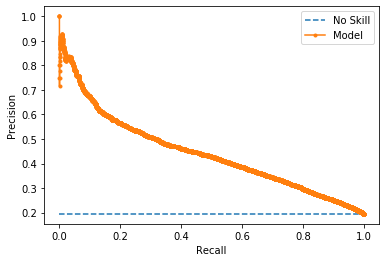

In [44]:
#precision-recall curve and AUC
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Model: auc=%.3f' % (lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Model')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In both figures, we compare the model to a random guess, and it turns out to perform significantly better.

We can also look at the most important features :

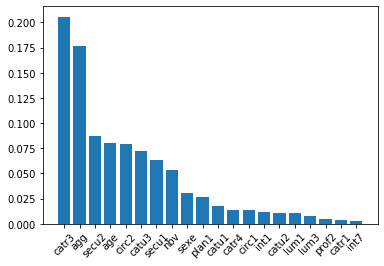

In [59]:
feats=pd.Series(model.feature_importances_,features).sort_values(ascending=False).head(20)
plt.bar(feats.index,feats.values)
plt.xticks(rotation=45)
plt.show()

In [60]:
df[['grav']+list(feats.index)].corr().head(1)

,grav,catr3,agg,secu2,age,circ2,catu3,secu1,nbv,sexe,...,catu1,catr4,circ1,int1,catu2,lum1,lum3,prof2,catr1,int7
grav,1.0,0.192445,-0.15459,0.170843,0.06055,0.145502,0.116092,-0.112247,-0.080143,-0.036653,...,-0.053705,-0.136156,-0.100611,0.062483,-0.009166,-0.034657,0.094468,0.058316,-0.076158,-0.02923


### Concluding remarks

We notice that the type of road (**catr** variable) plays a great part in the gravity of an accident. 
The use of a safety gear (**secu**) seems to reduce the risk.
Accidents in agglomerations tend to be less serious.
Obviously, this work is only a demo of what can be achieved with the given dataset and can still be improved. Other variables that we haven't accounted for can be introduced, and some that weren't necessary can be removed for additional model stability, for example via PCA. Also, model hyperparameters can be chosen more optimaly using a GridSearch.